#  Gathering DFT Descriptors from High-Throughput Calculations

This is a notebook to find and calculate DFT descriptors of the reduced form of the cofactors from the BMC data collected. Descriptors include: HOMO/LUMO energies, NBO charges at each key atom, fukui indices at each key atom (atoms in the ring and the first atom of each substituent), and buried volume at each key atom.

Required input is GoodVibes data for cofactors (Goodvibes_output.csv), a proton (proton_goodvibes_output.csv), and a hydride atom (hydride_goodvibes_output.csv). Single point calculation files with NBO, Hirshfeld, and C5 charges are also required. NBO charge files need to be in an sp_calcs/ folder, and Hirshfeld/CM5 charges need to be in a hirshfeld_calcs/ folder with the same file ending as NBO files from GoodVibes data.

Output will be a CSV file with atom indices for key atoms (key_atom_indices.csv) and a CSV file with dft descriptors for each BMC (bmc_reduced_dft_descriptors.csv).

## Importing Necessary Packages

In [1]:
# importing packages
import matplotlib.pyplot as plt
import glob 
import numpy as np
import math
import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem import rdqueries
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import rdRGroupDecomposition
from rdkit.Chem import rdDepictor
from rdkit import Geometry
rdDepictor.SetPreferCoordGen(True)
import itertools, random
import os, rdkit
import pandas as pd
from rdkit.Chem import PandasTools
from rdkit.Chem import rdChemReactions
from rdkit.Chem import Descriptors
import DISCO as cd 
import dbstep.Dbstep as db

/apps/conda/aplatt/envs/BMCs/lib/python3.9/site-packages/dbstep/sterics.py:16: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def parallel_grid_scan(xy_grid, angle):


## Defining Functions to be Used Throughout

In [2]:
# defining a function to make DISCO output not in list form
def flatten(l):
    flat_list = []
    for element in l:
        if type(element) is list:
            for item in element:
                flat_list.append(item)
        else:
            flat_list.append(element)
    return flat_list

In [3]:
# defining a function to extract hirshfeld and cm5 charges from a file and atom index
def get_hirshfeld_cm5(filename,idx):
    file = open(filename, 'r')
    lines = file.readlines()
    file.close()
    h_charges,cm5_charges = [],[]
    for i,line in enumerate(lines):
        if " Hirshfeld charges, spin densities, dipoles, and CM5 charges" in line:
            h_charges = [float(lines[i+2+index].split()[2]) for index in idx] #-1 makes it 1 indexed
            cm5_charges = [float(lines[i+2+index].split()[-1]) for index in idx] #-1 makes it 1 indexed
    return h_charges,cm5_charges

## Reading in GoodVibes Data

In [4]:
# reading in the dataframe and defining helpful variables
goodvibes = pd.read_csv('../Data/BMC_Library/Goodvibes_output.csv', header=12)
goodvibes.drop('Unnamed: 9', inplace=True, axis=1)
goodvibes.dropna(inplace=True)

struct = []
for value in goodvibes['   Structure'].str.split():
    struct.append(value[1])
goodvibes['Filename'] = struct
goodvibes['Structure Name'] = goodvibes['Filename'].apply(lambda x: x.rsplit('_',maxsplit=6)[0])
goodvibes['Conformer'] = goodvibes['Filename'].apply(lambda x: x.rsplit('_')[-2])

# removing NMNH from the data frame (comment out if want to include)
goodvibes = goodvibes[goodvibes['Structure Name'].str.contains('NMNH_2-')==False]
goodvibes = goodvibes[goodvibes['Structure Name'].str.contains('NMNH_1-')==False]
# goodvibes

## Calculating Delta G Values

In [5]:
# defining the helpful math variables
deltaG = goodvibes['qh-G(T)_SPC']
e_spc = goodvibes['E_SPC']
kb = 1.38e-23 #J K-1
kb_ha = kb / 4.35974e-18 #Ha K-1

goodvibes['Corrected Boltzmann Weight (no exp)'] = (-1 * e_spc) / (kb_ha * 298)
goodvibes['boltz'] = np.exp(goodvibes['Corrected Boltzmann Weight (no exp)'])

# creating a new dataframe including only the structure name and corrected free energy from corrected boltzmann weights
data = []
for groupid,group in goodvibes.groupby('Structure Name'):
    boltz_sum = group['Corrected Boltzmann Weight (no exp)'].sum()
    boltz_prob = group['Corrected Boltzmann Weight (no exp)']/boltz_sum
    free_energy = group['G(T)_SPC'] * boltz_prob
    free_energies = free_energy.sum()
    idx_gmin = group['G(T)_SPC'].idxmin()
    num_confs = group['Structure Name'].count()
    min_conf_file = group.loc[idx_gmin]['Filename']
    data.append((groupid, free_energies, min_conf_file, num_confs))


# creating a new, clean dataframe with only the names and energies
goodvibes_clean = pd.DataFrame(data, columns=['Structure Name', 'Corrected Free Energy', 'Lowest Conf Name', 'Number of Conformers'])
goodvibes_clean['Cofactor Name'] = goodvibes_clean['Structure Name'].apply(lambda x: x.rsplit('_',maxsplit=1)[0])
goodvibes_clean['Structure Type'] = goodvibes_clean['Structure Name'].apply(lambda x: x.rsplit('_',maxsplit=1)[-1])
# goodvibes_clean

/apps/conda/aplatt/envs/BMCs/lib/python3.9/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [6]:
# getting the free energy of a proton for dG calculations
proton_file_location = os.path.join('../Data/BMC_Library/proton_goodvibes.csv')
proton_filename = glob.glob(proton_file_location)

datafile = open('../Data/BMC_Library/proton_goodvibes.csv', 'r')
proton_data = datafile.readlines()
datafile.close()

proton_G = 0

for line in proton_data:
    if line.startswith('o') == True and ',' in line:
        dataline = line.split()[1]
        proton_G = dataline.split(',')[-3]

proton_G_kcal = float(proton_G) * 627.5

# getting the free energy of a hydride for dG calculations
hydride_file_location = os.path.join('../Data/BMC_Library/hydride_goodvibes.csv')
hydride_filename = glob.glob(hydride_file_location)

datafile = open('../Data/BMC_Library/hydride_goodvibes.csv', 'r')
hydride_data = datafile.readlines()
datafile.close()

hydride_G = 0

for line in hydride_data:
    if line.startswith('o') == True and ',' in line:
        dataline = line.split()[1]
        hydride_G = dataline.split(',')[-3]

hydride_G_kcal = float(hydride_G) * 627.5

In [7]:
# creating a new dataframe with the dG values for each reaction that we care about
pyr = (goodvibes_clean['Structure Type'] == 'pyridinium')
red = (goodvibes_clean['Structure Type'] == 'reduced')
inact = (goodvibes_clean['Structure Type'] == 'inactive')

good_pyr = goodvibes_clean[pyr]
good_red = goodvibes_clean[red]
good_inact = goodvibes_clean[inact]

thermo_data = pd.DataFrame(columns=['Cofactor', 'dG C4 Reduction (kcal/mol)', 'dG C5 Reduction (kcal/mol)'])

thermo_data['Cofactor'] = good_pyr['Cofactor Name']
thermo_data['dG C4 Reduction (kcal/mol)'] = (627.5 * good_red['Corrected Free Energy'].values) - (hydride_G_kcal + (627.5 * good_pyr['Corrected Free Energy'].values))
thermo_data['dG C5 Reduction (kcal/mol)'] = (627.5 * good_inact['Corrected Free Energy'].values) - (proton_G_kcal + (627.5 * good_red['Corrected Free Energy'].values))

thermo_data.reset_index(inplace=True)
thermo_data.drop('index', inplace=True, axis=1)

## Extracting Key Atom Indices from Files

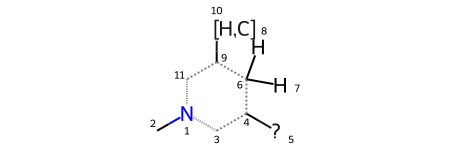

In [8]:
# defining the core and how to determine atom indicies for DISCO and Fukui calcs
nsmi = '[#7]1(-[#6])~[#6]~[#6](-[#6&!H3])~[#6](-[#1])(-[#1])~[#6](-[#1,#6])~[#6]~1'
ncore = Chem.MolFromSmarts(nsmi)

for i, atom in enumerate(ncore.GetAtoms()):
    # For each atom, set the property "molAtomMapNumber" to a custom number, let's say, the index of the atom in the molecule
    atom.SetProp("atomNote", str(atom.GetIdx()+1))
ncore 

In [9]:
# going through all singlepoint output files and saving the lowest energy structure filenames to a list
## cannot run without all log files in appropriate folders (not included in this GitHub repo)
log_files = []

file_location = os.path.join('sp_nbo', '*reduced*spc_nbo.log') #only finding reduced cofactors
filenames = glob.glob(file_location)
for f in filenames:
    file_name = os.path.basename(f)
    split_filename = file_name.split('_spc_nbo')
    conf_name = split_filename[0]
    for conf in goodvibes_clean['Lowest Conf Name']:
        if conf_name == conf:
            log_files.append(F'sp_nbo/{conf_name}_spc_nbo.log')

In [10]:
# changing nbo output log files into sdf files for rdkit
from openbabel import pybel

for file in log_files:
    newfile = file.split('/')[-1].split('.')[0]+'.sdf'
    mol = list(pybel.readfile("log", file))[0]
    mol.write('sdf',newfile, overwrite=True) #writes new sdf files in current working directory

BMC_004_reduced_censo_ensemble_clustered_conf_02_opt_spc_nbo.sdf
BMC_001_reduced_censo_ensemble_clustered_conf_01_opt_spc_nbo.sdf
BMC_005_reduced_censo_ensemble_clustered_conf_01_opt_spc_nbo.sdf
BMC_006_reduced_censo_ensemble_clustered_conf_01_opt_spc_nbo.sdf
BMC_002_reduced_censo_ensemble_clustered_conf_01_opt_spc_nbo.sdf
BMC_003_reduced_censo_ensemble_clustered_conf_01_opt_spc_nbo.sdf
BMC_011_reduced_censo_ensemble_clustered_conf_04_opt_spc_nbo.sdf
BMC_012_reduced_censo_ensemble_clustered_conf_01_opt_spc_nbo.sdf
BMC_013_reduced_censo_ensemble_clustered_conf_01_opt_spc_nbo.sdf
BMC_014_reduced_censo_ensemble_clustered_conf_01_opt_spc_nbo.sdf
BMC_015_reduced_censo_ensemble_clustered_conf_10_opt_spc_nbo.sdf
BMC_016_reduced_censo_ensemble_clustered_conf_07_opt_spc_nbo.sdf
BMC_017_reduced_censo_ensemble_clustered_conf_04_opt_spc_nbo.sdf
BMC_018_reduced_censo_ensemble_clustered_conf_03_opt_spc_nbo.sdf
BMC_019_reduced_censo_ensemble_clustered_conf_06_opt_spc_nbo.sdf
BMC_020_reduced_censo_ens

*** Open Babel Error  in ReadMolecule
  Problems reading an output file: Could not determine the format of this file. Please report it to the openbabel-discuss @ lists.sourceforge.net mailing list.
*** Open Babel Error  in ReadMolecule
  Problems reading an output file: Could not determine the format of this file. Please report it to the openbabel-discuss @ lists.sourceforge.net mailing list.
*** Open Babel Error  in ReadMolecule
  Problems reading an output file: Could not determine the format of this file. Please report it to the openbabel-discuss @ lists.sourceforge.net mailing list.
*** Open Babel Error  in ReadMolecule
  Problems reading an output file: Could not determine the format of this file. Please report it to the openbabel-discuss @ lists.sourceforge.net mailing list.
*** Open Babel Error  in ReadMolecule
  Problems reading an output file: Could not determine the format of this file. Please report it to the openbabel-discuss @ lists.sourceforge.net mailing list.
*** Open B

BMC_027_reduced_censo_ensemble_clustered_conf_01_opt_spc_nbo.sdf
BMC_028_reduced_censo_ensemble_clustered_conf_01_opt_spc_nbo.sdf
BMC_029_reduced_censo_ensemble_clustered_conf_03_opt_spc_nbo.sdf
BMC_030_reduced_censo_ensemble_clustered_conf_06_opt_spc_nbo.sdf
BMC_031_reduced_censo_ensemble_clustered_conf_07_opt_spc_nbo.sdf
BMC_032_reduced_censo_ensemble_clustered_conf_05_opt_spc_nbo.sdf
BMC_033_reduced_censo_ensemble_clustered_conf_01_opt_spc_nbo.sdf
BMC_037_reduced_censo_ensemble_clustered_conf_07_opt_spc_nbo.sdf
BMC_035_reduced_censo_ensemble_clustered_conf_09_opt_spc_nbo.sdf
BMC_034_reduced_censo_ensemble_clustered_conf_01_opt_spc_nbo.sdf
BMC_039_reduced_censo_ensemble_clustered_conf_05_opt_spc_nbo.sdf
BMC_036_reduced_censo_ensemble_clustered_conf_01_opt_spc_nbo.sdf
BMC_038_reduced_censo_ensemble_clustered_conf_05_opt_spc_nbo.sdf
BMC_041_reduced_censo_ensemble_clustered_conf_08_opt_spc_nbo.sdf


*** Open Babel Error  in ReadMolecule
  Problems reading an output file: Could not determine the format of this file. Please report it to the openbabel-discuss @ lists.sourceforge.net mailing list.
*** Open Babel Error  in ReadMolecule
  Problems reading an output file: Could not determine the format of this file. Please report it to the openbabel-discuss @ lists.sourceforge.net mailing list.
*** Open Babel Error  in ReadMolecule
  Problems reading an output file: Could not determine the format of this file. Please report it to the openbabel-discuss @ lists.sourceforge.net mailing list.
*** Open Babel Error  in ReadMolecule
  Problems reading an output file: Could not determine the format of this file. Please report it to the openbabel-discuss @ lists.sourceforge.net mailing list.
*** Open Babel Error  in ReadMolecule
  Problems reading an output file: Could not determine the format of this file. Please report it to the openbabel-discuss @ lists.sourceforge.net mailing list.
*** Open B

BMC_043_reduced_censo_ensemble_clustered_conf_06_opt_spc_nbo.sdf
BMC_065_reduced_censo_ensemble_clustered_conf_02_opt_spc_nbo.sdf
BMC_040_reduced_censo_ensemble_clustered_conf_01_opt_spc_nbo.sdf
BMC_042_reduced_censo_ensemble_clustered_conf_06_opt_spc_nbo.sdf
BMC_048_reduced_censo_ensemble_clustered_conf_03_opt_spc_nbo.sdf
BMC_075_reduced_censo_ensemble_clustered_conf_04_opt_spc_nbo.sdf
BMC_052_reduced_censo_ensemble_clustered_conf_01_opt_spc_nbo.sdf
BMC_044_reduced_censo_ensemble_clustered_conf_10_opt_spc_nbo.sdf
BMC_053_reduced_censo_ensemble_clustered_conf_01_opt_spc_nbo.sdf
BMC_045_reduced_censo_ensemble_clustered_conf_03_opt_spc_nbo.sdf
BMC_047_reduced_censo_ensemble_clustered_conf_02_opt_spc_nbo.sdf
BMC_046_reduced_censo_ensemble_clustered_conf_03_opt_spc_nbo.sdf


*** Open Babel Error  in ReadMolecule
  Problems reading an output file: Could not determine the format of this file. Please report it to the openbabel-discuss @ lists.sourceforge.net mailing list.
*** Open Babel Error  in ReadMolecule
  Problems reading an output file: Could not determine the format of this file. Please report it to the openbabel-discuss @ lists.sourceforge.net mailing list.
*** Open Babel Error  in ReadMolecule
  Problems reading an output file: Could not determine the format of this file. Please report it to the openbabel-discuss @ lists.sourceforge.net mailing list.
*** Open Babel Error  in ReadMolecule
  Problems reading an output file: Could not determine the format of this file. Please report it to the openbabel-discuss @ lists.sourceforge.net mailing list.
*** Open Babel Error  in ReadMolecule
  Problems reading an output file: Could not determine the format of this file. Please report it to the openbabel-discuss @ lists.sourceforge.net mailing list.
*** Open B

BMC_054_reduced_censo_ensemble_clustered_conf_02_opt_spc_nbo.sdf
BMC_055_reduced_censo_ensemble_clustered_conf_01_opt_spc_nbo.sdf
BMC_061_reduced_censo_ensemble_clustered_conf_01_opt_spc_nbo.sdf
BMC_073_reduced_censo_ensemble_clustered_conf_01_opt_spc_nbo.sdf
BMC_059_reduced_censo_ensemble_clustered_conf_01_opt_spc_nbo.sdf
BMC_056_reduced_censo_ensemble_clustered_conf_02_opt_spc_nbo.sdf
BMC_057_reduced_censo_ensemble_clustered_conf_01_opt_spc_nbo.sdf
BMC_062_reduced_censo_ensemble_clustered_conf_01_opt_spc_nbo.sdf
BMC_071_reduced_censo_ensemble_clustered_conf_02_opt_spc_nbo.sdf


*** Open Babel Error  in ReadMolecule
  Problems reading an output file: Could not determine the format of this file. Please report it to the openbabel-discuss @ lists.sourceforge.net mailing list.
*** Open Babel Error  in ReadMolecule
  Problems reading an output file: Could not determine the format of this file. Please report it to the openbabel-discuss @ lists.sourceforge.net mailing list.
*** Open Babel Error  in ReadMolecule
  Problems reading an output file: Could not determine the format of this file. Please report it to the openbabel-discuss @ lists.sourceforge.net mailing list.
*** Open Babel Error  in ReadMolecule
  Problems reading an output file: Could not determine the format of this file. Please report it to the openbabel-discuss @ lists.sourceforge.net mailing list.
*** Open Babel Error  in ReadMolecule
  Problems reading an output file: Could not determine the format of this file. Please report it to the openbabel-discuss @ lists.sourceforge.net mailing list.
*** Open B

BMC_072_reduced_censo_ensemble_clustered_conf_01_opt_spc_nbo.sdf
BMC_066_reduced_censo_ensemble_clustered_conf_01_opt_spc_nbo.sdf
BMC_068_reduced_censo_ensemble_clustered_conf_02_opt_spc_nbo.sdf
BMC_076_reduced_censo_ensemble_clustered_conf_01_opt_spc_nbo.sdf
BMC_070_reduced_censo_ensemble_clustered_conf_02_opt_spc_nbo.sdf
BMC_086_reduced_censo_ensemble_clustered_conf_06_opt_spc_nbo.sdf
BMC_087_reduced_censo_ensemble_clustered_conf_01_opt_spc_nbo.sdf
BMC_088_reduced_censo_ensemble_clustered_conf_01_opt_spc_nbo.sdf


*** Open Babel Error  in ReadMolecule
  Problems reading an output file: Could not determine the format of this file. Please report it to the openbabel-discuss @ lists.sourceforge.net mailing list.
*** Open Babel Error  in ReadMolecule
  Problems reading an output file: Could not determine the format of this file. Please report it to the openbabel-discuss @ lists.sourceforge.net mailing list.
*** Open Babel Error  in ReadMolecule
  Problems reading an output file: Could not determine the format of this file. Please report it to the openbabel-discuss @ lists.sourceforge.net mailing list.
*** Open Babel Error  in ReadMolecule
  Problems reading an output file: Could not determine the format of this file. Please report it to the openbabel-discuss @ lists.sourceforge.net mailing list.
*** Open Babel Error  in ReadMolecule
  Problems reading an output file: Could not determine the format of this file. Please report it to the openbabel-discuss @ lists.sourceforge.net mailing list.
*** Open B

BMC_079_reduced_censo_ensemble_clustered_conf_03_opt_spc_nbo.sdf
BMC_077_reduced_censo_ensemble_clustered_conf_10_opt_spc_nbo.sdf
BMC_085_reduced_censo_ensemble_clustered_conf_04_opt_spc_nbo.sdf
BMC_082_reduced_censo_ensemble_clustered_conf_01_opt_spc_nbo.sdf
BMC_084_reduced_censo_ensemble_clustered_conf_10_opt_spc_nbo.sdf
BMC_078_reduced_censo_ensemble_clustered_conf_10_opt_spc_nbo.sdf
BMC_080_reduced_censo_ensemble_clustered_conf_10_opt_spc_nbo.sdf
BMC_081_reduced_censo_ensemble_clustered_conf_01_opt_spc_nbo.sdf


*** Open Babel Error  in ReadMolecule
  Problems reading an output file: Could not determine the format of this file. Please report it to the openbabel-discuss @ lists.sourceforge.net mailing list.
*** Open Babel Error  in ReadMolecule
  Problems reading an output file: Could not determine the format of this file. Please report it to the openbabel-discuss @ lists.sourceforge.net mailing list.
*** Open Babel Error  in ReadMolecule
  Problems reading an output file: Could not determine the format of this file. Please report it to the openbabel-discuss @ lists.sourceforge.net mailing list.
*** Open Babel Error  in ReadMolecule
  Problems reading an output file: Could not determine the format of this file. Please report it to the openbabel-discuss @ lists.sourceforge.net mailing list.
*** Open Babel Error  in ReadMolecule
  Problems reading an output file: Could not determine the format of this file. Please report it to the openbabel-discuss @ lists.sourceforge.net mailing list.
*** Open B

BMC_095_reduced_censo_ensemble_clustered_conf_02_opt_spc_nbo.sdf
BMC_097_reduced_censo_ensemble_clustered_conf_01_opt_spc_nbo.sdf
BMC_102_reduced_censo_ensemble_clustered_conf_04_opt_spc_nbo.sdf
BMC_089_reduced_censo_ensemble_clustered_conf_01_opt_spc_nbo.sdf
BMC_093_reduced_censo_ensemble_clustered_conf_03_opt_spc_nbo.sdf
BMC_090_reduced_censo_ensemble_clustered_conf_07_opt_spc_nbo.sdf
BMC_092_reduced_censo_ensemble_clustered_conf_06_opt_spc_nbo.sdf
BMC_091_reduced_censo_ensemble_clustered_conf_01_opt_spc_nbo.sdf
BMC_096_reduced_censo_ensemble_clustered_conf_01_opt_spc_nbo.sdf
BMC_098_reduced_censo_ensemble_clustered_conf_09_opt_spc_nbo.sdf
BMC_101_reduced_censo_ensemble_clustered_conf_01_opt_spc_nbo.sdf
BMC_099_reduced_censo_ensemble_clustered_conf_10_opt_spc_nbo.sdf


*** Open Babel Error  in ReadMolecule
  Problems reading an output file: Could not determine the format of this file. Please report it to the openbabel-discuss @ lists.sourceforge.net mailing list.
*** Open Babel Error  in ReadMolecule
  Problems reading an output file: Could not determine the format of this file. Please report it to the openbabel-discuss @ lists.sourceforge.net mailing list.
*** Open Babel Error  in ReadMolecule
  Problems reading an output file: Could not determine the format of this file. Please report it to the openbabel-discuss @ lists.sourceforge.net mailing list.
*** Open Babel Error  in ReadMolecule
  Problems reading an output file: Could not determine the format of this file. Please report it to the openbabel-discuss @ lists.sourceforge.net mailing list.
*** Open Babel Error  in ReadMolecule
  Problems reading an output file: Could not determine the format of this file. Please report it to the openbabel-discuss @ lists.sourceforge.net mailing list.
*** Open B

BMC_103_reduced_censo_ensemble_clustered_conf_09_opt_spc_nbo.sdf
BMC_104_reduced_censo_ensemble_clustered_conf_01_opt_spc_nbo.sdf
BMC_106_reduced_censo_ensemble_clustered_conf_10_opt_spc_nbo.sdf
BMC_105_reduced_censo_ensemble_clustered_conf_08_opt_spc_nbo.sdf
BMC_108_reduced_censo_ensemble_clustered_conf_01_opt_spc_nbo.sdf
BMC_100_reduced_censo_ensemble_clustered_conf_02_opt_spc_nbo.sdf
BMC_107_reduced_censo_ensemble_clustered_conf_10_opt_spc_nbo.sdf
BMC_007_reduced_censo_ensemble_clustered_conf_01_opt_spc_nbo.sdf
BMC_008_reduced_censo_ensemble_clustered_conf_02_opt_spc_nbo.sdf
BMC_009_reduced_censo_ensemble_clustered_conf_01_opt_spc_nbo.sdf
BMC_010_reduced_censo_ensemble_clustered_conf_01_opt_spc_nbo.sdf
BMC_049_reduced_censo_ensemble_clustered_conf_01_opt_spc_nbo.sdf


*** Open Babel Error  in ReadMolecule
  Problems reading an output file: Could not determine the format of this file. Please report it to the openbabel-discuss @ lists.sourceforge.net mailing list.
*** Open Babel Error  in ReadMolecule
  Problems reading an output file: Could not determine the format of this file. Please report it to the openbabel-discuss @ lists.sourceforge.net mailing list.
*** Open Babel Error  in ReadMolecule
  Problems reading an output file: Could not determine the format of this file. Please report it to the openbabel-discuss @ lists.sourceforge.net mailing list.
*** Open Babel Error  in ReadMolecule
  Problems reading an output file: Could not determine the format of this file. Please report it to the openbabel-discuss @ lists.sourceforge.net mailing list.
*** Open Babel Error  in ReadMolecule
  Problems reading an output file: Could not determine the format of this file. Please report it to the openbabel-discuss @ lists.sourceforge.net mailing list.
*** Open B

BMC_050_reduced_censo_ensemble_clustered_conf_01_opt_spc_nbo.sdf
BMC_051_reduced_censo_ensemble_clustered_conf_01_opt_spc_nbo.sdf
BMC_058_reduced_censo_ensemble_clustered_conf_02_opt_spc_nbo.sdf
BMC_060_reduced_censo_ensemble_clustered_conf_03_opt_spc_nbo.sdf
BMC_063_reduced_censo_ensemble_clustered_conf_03_opt_spc_nbo.sdf
BMC_067_reduced_censo_ensemble_clustered_conf_01_opt_spc_nbo.sdf
BMC_069_reduced_censo_ensemble_clustered_conf_01_opt_spc_nbo.sdf
BMC_064_reduced_censo_ensemble_clustered_conf_02_opt_spc_nbo.sdf
BMC_074_reduced_censo_ensemble_clustered_conf_01_opt_spc_nbo.sdf
BMC_083_reduced_censo_ensemble_clustered_conf_05_opt_spc_nbo.sdf
BMC_094_reduced_censo_ensemble_clustered_conf_01_opt_spc_nbo.sdf


*** Open Babel Error  in ReadMolecule
  Problems reading an output file: Could not determine the format of this file. Please report it to the openbabel-discuss @ lists.sourceforge.net mailing list.
*** Open Babel Error  in ReadMolecule
  Problems reading an output file: Could not determine the format of this file. Please report it to the openbabel-discuss @ lists.sourceforge.net mailing list.
*** Open Babel Error  in ReadMolecule
  Problems reading an output file: Could not determine the format of this file. Please report it to the openbabel-discuss @ lists.sourceforge.net mailing list.
*** Open Babel Error  in ReadMolecule
  Problems reading an output file: Could not determine the format of this file. Please report it to the openbabel-discuss @ lists.sourceforge.net mailing list.
*** Open Babel Error  in ReadMolecule
  Problems reading an output file: Could not determine the format of this file. Please report it to the openbabel-discuss @ lists.sourceforge.net mailing list.
*** Open B

BMC_109_reduced_censo_ensemble_clustered_conf_02_opt_spc_nbo.sdf
BMC_110_reduced_censo_ensemble_clustered_conf_02_opt_spc_nbo.sdf
BMC_116_reduced_censo_ensemble_clustered_conf_02_opt_spc_nbo.sdf
BMC_111_reduced_censo_ensemble_clustered_conf_10_opt_spc_nbo.sdf
BMC_112_reduced_censo_ensemble_clustered_conf_01_opt_spc_nbo.sdf
BMC_118_reduced_censo_ensemble_clustered_conf_04_opt_spc_nbo.sdf
BMC_113_reduced_censo_ensemble_clustered_conf_01_opt_spc_nbo.sdf
BMC_115_reduced_censo_ensemble_clustered_conf_01_opt_spc_nbo.sdf
BMC_114_reduced_censo_ensemble_clustered_conf_01_opt_spc_nbo.sdf
BMC_117_reduced_censo_ensemble_clustered_conf_04_opt_spc_nbo.sdf
BMC_119_reduced_censo_ensemble_clustered_conf_02_opt_spc_nbo.sdf
BMC_126_reduced_censo_ensemble_clustered_conf_02_opt_spc_nbo.sdf


*** Open Babel Error  in ReadMolecule
  Problems reading an output file: Could not determine the format of this file. Please report it to the openbabel-discuss @ lists.sourceforge.net mailing list.
*** Open Babel Error  in ReadMolecule
  Problems reading an output file: Could not determine the format of this file. Please report it to the openbabel-discuss @ lists.sourceforge.net mailing list.
*** Open Babel Error  in ReadMolecule
  Problems reading an output file: Could not determine the format of this file. Please report it to the openbabel-discuss @ lists.sourceforge.net mailing list.
*** Open Babel Error  in ReadMolecule
  Problems reading an output file: Could not determine the format of this file. Please report it to the openbabel-discuss @ lists.sourceforge.net mailing list.
*** Open Babel Error  in ReadMolecule
  Problems reading an output file: Could not determine the format of this file. Please report it to the openbabel-discuss @ lists.sourceforge.net mailing list.
*** Open B

BMC_120_reduced_censo_ensemble_clustered_conf_03_opt_spc_nbo.sdf
BMC_122_reduced_censo_ensemble_clustered_conf_06_opt_spc_nbo.sdf
BMC_124_reduced_censo_ensemble_clustered_conf_01_opt_spc_nbo.sdf
BMC_128_reduced_censo_ensemble_clustered_conf_01_opt_spc_nbo.sdf
BMC_121_reduced_censo_ensemble_clustered_conf_06_opt_spc_nbo.sdf
BMC_125_reduced_censo_ensemble_clustered_conf_03_opt_spc_nbo.sdf
BMC_129_reduced_censo_ensemble_clustered_conf_01_opt_spc_nbo.sdf
BMC_123_reduced_censo_ensemble_clustered_conf_06_opt_spc_nbo.sdf


*** Open Babel Error  in ReadMolecule
  Problems reading an output file: Could not determine the format of this file. Please report it to the openbabel-discuss @ lists.sourceforge.net mailing list.
*** Open Babel Error  in ReadMolecule
  Problems reading an output file: Could not determine the format of this file. Please report it to the openbabel-discuss @ lists.sourceforge.net mailing list.
*** Open Babel Error  in ReadMolecule
  Problems reading an output file: Could not determine the format of this file. Please report it to the openbabel-discuss @ lists.sourceforge.net mailing list.
*** Open Babel Error  in ReadMolecule
  Problems reading an output file: Could not determine the format of this file. Please report it to the openbabel-discuss @ lists.sourceforge.net mailing list.
*** Open Babel Error  in ReadMolecule
  Problems reading an output file: Could not determine the format of this file. Please report it to the openbabel-discuss @ lists.sourceforge.net mailing list.
*** Open B

BMC_127_reduced_censo_ensemble_clustered_conf_01_opt_spc_nbo.sdf
BMC_130_reduced_censo_ensemble_clustered_conf_01_opt_spc_nbo.sdf
BMC_131_reduced_censo_ensemble_clustered_conf_01_opt_spc_nbo.sdf
BMC_132_reduced_censo_ensemble_clustered_conf_01_opt_spc_nbo.sdf


*** Open Babel Error  in ReadMolecule
  Problems reading an output file: Could not determine the format of this file. Please report it to the openbabel-discuss @ lists.sourceforge.net mailing list.
*** Open Babel Error  in ReadMolecule
  Problems reading an output file: Could not determine the format of this file. Please report it to the openbabel-discuss @ lists.sourceforge.net mailing list.
*** Open Babel Error  in ReadMolecule
  Problems reading an output file: Could not determine the format of this file. Please report it to the openbabel-discuss @ lists.sourceforge.net mailing list.
*** Open Babel Error  in ReadMolecule
  Problems reading an output file: Could not determine the format of this file. Please report it to the openbabel-discuss @ lists.sourceforge.net mailing list.


In [11]:
# reading in the sdf files as rdkit mol objects
bmc_mols = []

sdf_file_location = os.path.join('*.sdf')
sdf_filenames = glob.glob(sdf_file_location)
for f in sdf_filenames:
    sdf_file_name = os.path.basename(f)
    mol = Chem.SDMolSupplier(sdf_file_name,removeHs=False)[0]
    bmc_mols.append(mol)

/apps/conda/aplatt/envs/BMCs/lib/python3.9/site-packages/rdkit/Chem/Draw/IPythonConsole.py:261: UserWarning: Truncating the list of molecules to be displayed to 50. Change the maxMols value to display more.
  warnings.warn(


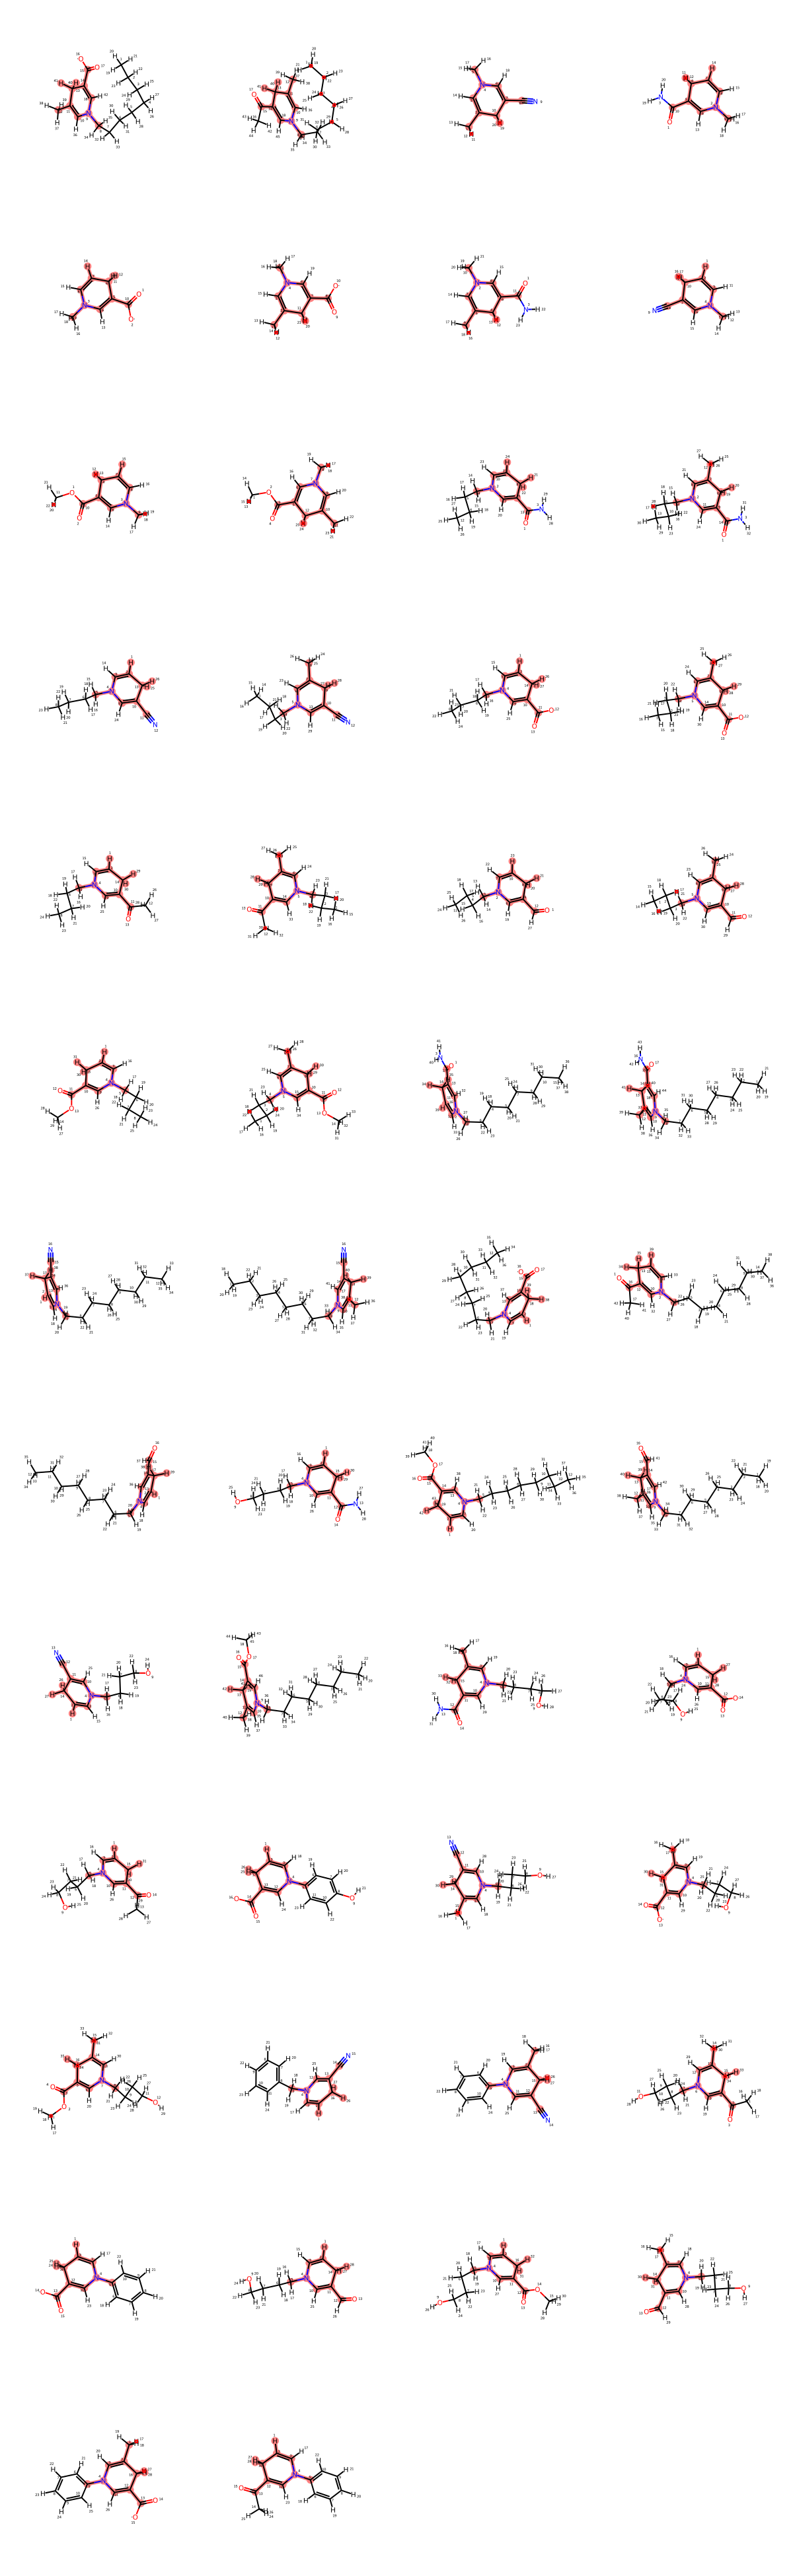

In [12]:
# showing the matches in pretty pictures on my molecules
matches,vismatches= [],[]
for mol in bmc_mols:
    for i, atom in enumerate(mol.GetAtoms()):
        # For each atom, set the property "molAtomMapNumber" to a custom number, let's say, the index of the atom in the molecule
        atom.SetProp("atomNote", str(atom.GetIdx()+1))

    match = mol.GetSubstructMatch(ncore)
    vismatches.append(match) # 0 indexed for visualization
    match = [m+1 for m in match]
    matches.append(tuple(match)) # 1 indexed for disco/gaussian
    
Draw.MolsToGridImage(bmc_mols,molsPerRow=4,highlightAtomLists=vismatches,subImgSize=(300,300)    )

In [13]:
# generating a dataframe with the name of the log file and atom indicies corresponding to each atom I care about
new_files = []
for file in sdf_filenames:
    new_file = file.split('.')[0]+'.log'
    new_files.append(new_file)

disco_data = pd.DataFrame(matches, columns=['N1', 'Nsub', 'C2', 'C3', 'C3sub', 'C4', 'C4H1', 'C4H2', 'C5', 'C5sub', 'C6'])
disco_data['Lowest E Conf File Name'] = new_files

atom_indices = disco_data

## Extracting NBO Charges Using DISCO

In [14]:
# looping through the dataframe and applying discso
disco_results = pd.DataFrame()
disco_results['Atom'] = ['N1', 'Nsub', 'C2', 'C3', 'C3sub', 'C4', 'C4H1', 'C4H2', 'C5', 'C5sub', 'C6']

red_homo_list = []
red_lumo_list = []

for index,row in disco_data.iterrows():
    file = os.path.join('sp_nbo', row['Lowest E Conf File Name']) #NEED TO CHANGE WHEN ON BUZZSAW
    molecule_name = (file.split('/')[-1]).split('_censo')[0]
    molecule_charges = []
    molecule_homo = []
    molecule_lumo = []
    for atom in row[:-1]:
        mol = cd.disco(file, charge=str(atom), mo=True, verbose=False)
        charge = mol.Chrg 
        homo = mol.HOMO
        lumo = mol.LUMO 
        molecule_charges.append(charge)
    if 'reduced' in file:
        disco_results[F'{molecule_name}_charge'] = flatten(molecule_charges)
        red_homo_list.append(homo)
        red_lumo_list.append(lumo)

dict = {'HOMO' : flatten(red_homo_list),
        'LUMO' : flatten(red_lumo_list)}

disco_mo_data = pd.DataFrame(dict)

/tmp/ipykernel_995023/124442943.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  disco_results[F'{molecule_name}_charge'] = flatten(molecule_charges)
/tmp/ipykernel_995023/124442943.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  disco_results[F'{molecule_name}_charge'] = flatten(molecule_charges)
/tmp/ipykernel_995023/124442943.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once usi

/tmp/ipykernel_995023/124442943.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  disco_results[F'{molecule_name}_charge'] = flatten(molecule_charges)
/tmp/ipykernel_995023/124442943.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  disco_results[F'{molecule_name}_charge'] = flatten(molecule_charges)
/tmp/ipykernel_995023/124442943.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once usi

In [15]:
# organizing the DISCO results into multiple datafraes for sorting
disco_temp = disco_results.set_index('Atom').transpose()
disco_temp = disco_temp.reset_index()

disco_red = disco_temp.loc[disco_temp['index'].str.contains('red')].reset_index(drop=True)
disco_red.columns = [col+'_NBO-q' for col in disco_red.columns]
disco_red['temp'] = disco_red['index_NBO-q'].str.find(' red')
disco_red['Cofactor'] = disco_red['index_NBO-q'].apply(lambda x: x.split('_reduced')[0])
disco_red = disco_red.drop(columns=['temp', 'index_NBO-q'])

In [16]:
# starting generation of the full, all data dataframe
BMC_data = disco_mo_data

BMC_data.insert(0, 'Cofactor', thermo_data['Cofactor'])
BMC_data['dG_C4_kcal'] = thermo_data['dG C4 Reduction (kcal/mol)']
BMC_data['dG_C5_kcal'] = thermo_data['dG C5 Reduction (kcal/mol)']

## Extracting Fukui Indices from Key Atoms

In [17]:
# going through all nbo output files and saving the lowest energy structure filenames to a list
csv_files = []

file_location = os.path.join('fukui_calcs', 'BMC*reduced*csv') #NEED TO CHANGE WHEN ON BUZZSAW
filenames = glob.glob(file_location)
for f in filenames:
    file_name = os.path.basename(f)
    split_filename = file_name.split('_opt')
    conf_name = split_filename[0]
    for conf in goodvibes_clean['Lowest Conf Name']:
        if F'{conf_name}_optimization' == conf:
            csv_files.append(F'fukui_calcs/{conf_name}_opt_fukui_indices.csv') #NEED TO CHANGE WHEN ON BUZZSAW

fukui_file_help = []

for index,row in disco_data.iterrows():
    new_file_name = row['Lowest E Conf File Name'].split('_spc_nbo.log')[0]
    new_fukui_filename = F'{new_file_name}_fukui_indices.csv'
    fukui_file_help.append(new_fukui_filename)
    
fukui_data = pd.DataFrame(matches, columns=['N1', 'Nsub', 'C2', 'C3', 'C3sub', 'C4', 'C4H1', 'C4H2', 'C5', 'C5sub', 'C6'])
fukui_data['Fukui File Name'] = fukui_file_help

In [18]:
f_files = []
for f in filenames:
#     print(f)
    filename_only = f.split('/')[1]
    f_files.append(filename_only)

len(f_files)
list(fukui_data['Fukui File Name'][-30:])

['BMC_067_reduced_censo_ensemble_clustered_conf_01_opt_fukui_indices.csv',
 'BMC_069_reduced_censo_ensemble_clustered_conf_01_opt_fukui_indices.csv',
 'BMC_064_reduced_censo_ensemble_clustered_conf_02_opt_fukui_indices.csv',
 'BMC_074_reduced_censo_ensemble_clustered_conf_01_opt_fukui_indices.csv',
 'BMC_083_reduced_censo_ensemble_clustered_conf_05_opt_fukui_indices.csv',
 'BMC_094_reduced_censo_ensemble_clustered_conf_01_opt_fukui_indices.csv',
 'BMC_109_reduced_censo_ensemble_clustered_conf_02_opt_fukui_indices.csv',
 'BMC_110_reduced_censo_ensemble_clustered_conf_02_opt_fukui_indices.csv',
 'BMC_116_reduced_censo_ensemble_clustered_conf_02_opt_fukui_indices.csv',
 'BMC_111_reduced_censo_ensemble_clustered_conf_10_opt_fukui_indices.csv',
 'BMC_112_reduced_censo_ensemble_clustered_conf_01_opt_fukui_indices.csv',
 'BMC_118_reduced_censo_ensemble_clustered_conf_04_opt_fukui_indices.csv',
 'BMC_113_reduced_censo_ensemble_clustered_conf_01_opt_fukui_indices.csv',
 'BMC_115_reduced_censo_e

In [22]:
# looping through the dataframe and finding fukui indices
fukui_results = pd.DataFrame()
fukui_results['Atom'] = ['N1', 'Nsub', 'C2', 'C3', 'C3sub', 'C4', 'C4H1', 'C4H2', 'C5', 'C5sub', 'C6']

red_fneg_N1_list, red_fneg_Nsub1_list, red_fneg_C2_list, red_fneg_C3_list, red_fneg_C3sub1_list =[],[],[],[],[] 
red_fneg_C4_list, red_fneg_C5_list, red_fneg_C5sub1_list, red_fneg_C6_list = [],[],[],[]
red_fneg_C4H1_list, red_fneg_C4H2_list = [],[]

red_fpos_N1_list, red_fpos_Nsub1_list, red_fpos_C2_list, red_fpos_C3_list, red_fpos_C3sub1_list =[],[],[],[],[] 
red_fpos_C4_list, red_fpos_C5_list, red_fpos_C5sub1_list, red_fpos_C6_list = [],[],[],[]
red_fpos_C4H1_list, red_fpos_C4H2_list = [],[]

mol_name = []

for index,row in fukui_data.iterrows():
    file = os.path.join('fukui_calcs', row['Fukui File Name'])
    
    molecule_name = (file.split('/')[1]).split('_censo')[0]
    molecule_fpos = []
    molecule_fneg = []
    mol_name.append(molecule_name)
    
    for atom in row[:-1]:
        if os.path.exists(file):
            data = pd.read_csv(file)
            fpos = data.loc[data['idx'] == atom]['f+'].values
            fneg = data.loc[data['idx'] == atom]['f-'].values
                
            if 'reduced' in file:
                if atom == row[:-1][0]:
                    red_fpos_N1_list.append(fpos)
                    red_fneg_N1_list.append(fneg)
                elif atom == row[:-1][1]:
                    red_fpos_Nsub1_list.append(fpos)
                    red_fneg_Nsub1_list.append(fneg)
                elif atom == row[:-1][2]:
                    red_fpos_C2_list.append(fpos)
                    red_fneg_C2_list.append(fneg)
                elif atom == row[:-1][3]:
                    red_fpos_C3_list.append(fpos)
                    red_fneg_C3_list.append(fneg)
                elif atom == row[:-1][4]:
                    red_fpos_C3sub1_list.append(fpos)
                    red_fneg_C3sub1_list.append(fneg)
                elif atom == row[:-1][5]:
                    red_fpos_C4_list.append(fpos)
                    red_fneg_C4_list.append(fneg)
                elif atom == row[:-1][6]:
                    red_fpos_C4H1_list.append(fpos)
                    red_fneg_C4H1_list.append(fneg)
                elif atom == row[:-1][7]:
                    red_fpos_C4H2_list.append(fpos)
                    red_fneg_C4H2_list.append(fneg)
                elif atom == row[:-1][8]:
                    red_fpos_C5_list.append(fpos)
                    red_fneg_C5_list.append(fneg)
                elif atom == row[:-1][9]:
                    red_fpos_C5sub1_list.append(fpos)
                    red_fneg_C5sub1_list.append(fneg)
                elif atom == row[:-1][10]:
                    red_fpos_C6_list.append(fpos)
                    red_fneg_C6_list.append(fneg)

        else:
            fpos = None
            fneg = None
                
            if 'reduced' in file:
                if atom == row[:-1][0]:
                    red_fpos_N1_list.append(fpos)
                    red_fneg_N1_list.append(fneg)
                elif atom == row[:-1][1]:
                    red_fpos_Nsub1_list.append(fpos)
                    red_fneg_Nsub1_list.append(fneg)
                elif atom == row[:-1][2]:
                    red_fpos_C2_list.append(fpos)
                    red_fneg_C2_list.append(fneg)
                elif atom == row[:-1][3]:
                    red_fpos_C3_list.append(fpos)
                    red_fneg_C3_list.append(fneg)
                elif atom == row[:-1][4]:
                    red_fpos_C3sub1_list.append(fpos)
                    red_fneg_C3sub1_list.append(fneg)
                elif atom == row[:-1][5]:
                    red_fpos_C4_list.append(fpos)
                    red_fneg_C4_list.append(fneg)
                elif atom == row[:-1][6]:
                    red_fpos_C4H1_list.append(fpos)
                    red_fneg_C4H1_list.append(fneg)
                elif atom == row[:-1][7]:
                    red_fpos_C4H2_list.append(fpos)
                    red_fneg_C4H2_list.append(fneg)
                elif atom == row[:-1][8]:
                    red_fpos_C5_list.append(fpos)
                    red_fneg_C5_list.append(fneg)
                elif atom == row[:-1][9]:
                    red_fpos_C5sub1_list.append(fpos)
                    red_fneg_C5sub1_list.append(fneg)
                elif atom == row[:-1][10]:
                    red_fpos_C6_list.append(fpos)
                    red_fneg_C6_list.append(fneg)

/tmp/ipykernel_995023/3112822631.py:30: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if atom == row[:-1][0]:
/tmp/ipykernel_995023/3112822631.py:30: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if atom == row[:-1][0]:
/tmp/ipykernel_995023/3112822631.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif atom == row[:-1][1]:
/tmp/ipykernel_995023/3112822631.py:30: FutureWarning: Series.__getitem__ treating keys as positions is 

/tmp/ipykernel_995023/3112822631.py:30: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if atom == row[:-1][0]:
/tmp/ipykernel_995023/3112822631.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif atom == row[:-1][1]:
/tmp/ipykernel_995023/3112822631.py:30: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if atom == row[:-1][0]:
/tmp/ipykernel_995023/3112822631.py:33: FutureWarning: Series.__getitem__ treating keys as positions is 

/tmp/ipykernel_995023/3112822631.py:30: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if atom == row[:-1][0]:
/tmp/ipykernel_995023/3112822631.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif atom == row[:-1][1]:
/tmp/ipykernel_995023/3112822631.py:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif atom == row[:-1][2]:
/tmp/ipykernel_995023/3112822631.py:39: FutureWarning: Series.__getitem__ treating keys as positions i

/tmp/ipykernel_995023/3112822631.py:30: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if atom == row[:-1][0]:
/tmp/ipykernel_995023/3112822631.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif atom == row[:-1][1]:
/tmp/ipykernel_995023/3112822631.py:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif atom == row[:-1][2]:
/tmp/ipykernel_995023/3112822631.py:39: FutureWarning: Series.__getitem__ treating keys as positions i

/tmp/ipykernel_995023/3112822631.py:30: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if atom == row[:-1][0]:
/tmp/ipykernel_995023/3112822631.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif atom == row[:-1][1]:
/tmp/ipykernel_995023/3112822631.py:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif atom == row[:-1][2]:
/tmp/ipykernel_995023/3112822631.py:39: FutureWarning: Series.__getitem__ treating keys as positions i

/tmp/ipykernel_995023/3112822631.py:30: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if atom == row[:-1][0]:
/tmp/ipykernel_995023/3112822631.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif atom == row[:-1][1]:
/tmp/ipykernel_995023/3112822631.py:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif atom == row[:-1][2]:
/tmp/ipykernel_995023/3112822631.py:39: FutureWarning: Series.__getitem__ treating keys as positions i

/tmp/ipykernel_995023/3112822631.py:30: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if atom == row[:-1][0]:
/tmp/ipykernel_995023/3112822631.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif atom == row[:-1][1]:
/tmp/ipykernel_995023/3112822631.py:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif atom == row[:-1][2]:
/tmp/ipykernel_995023/3112822631.py:39: FutureWarning: Series.__getitem__ treating keys as positions i

/tmp/ipykernel_995023/3112822631.py:30: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if atom == row[:-1][0]:
/tmp/ipykernel_995023/3112822631.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif atom == row[:-1][1]:
/tmp/ipykernel_995023/3112822631.py:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif atom == row[:-1][2]:
/tmp/ipykernel_995023/3112822631.py:39: FutureWarning: Series.__getitem__ treating keys as positions i

/tmp/ipykernel_995023/3112822631.py:30: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if atom == row[:-1][0]:
/tmp/ipykernel_995023/3112822631.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif atom == row[:-1][1]:
/tmp/ipykernel_995023/3112822631.py:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif atom == row[:-1][2]:
/tmp/ipykernel_995023/3112822631.py:39: FutureWarning: Series.__getitem__ treating keys as positions i

/tmp/ipykernel_995023/3112822631.py:30: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if atom == row[:-1][0]:
/tmp/ipykernel_995023/3112822631.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif atom == row[:-1][1]:
/tmp/ipykernel_995023/3112822631.py:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif atom == row[:-1][2]:
/tmp/ipykernel_995023/3112822631.py:39: FutureWarning: Series.__getitem__ treating keys as positions i

/tmp/ipykernel_995023/3112822631.py:30: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if atom == row[:-1][0]:
/tmp/ipykernel_995023/3112822631.py:30: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if atom == row[:-1][0]:
/tmp/ipykernel_995023/3112822631.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif atom == row[:-1][1]:
/tmp/ipykernel_995023/3112822631.py:30: FutureWarning: Series.__getitem__ treating keys as positions is 

/tmp/ipykernel_995023/3112822631.py:30: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if atom == row[:-1][0]:
/tmp/ipykernel_995023/3112822631.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif atom == row[:-1][1]:
/tmp/ipykernel_995023/3112822631.py:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif atom == row[:-1][2]:
/tmp/ipykernel_995023/3112822631.py:30: FutureWarning: Series.__getitem__ treating keys as positions i

/tmp/ipykernel_995023/3112822631.py:30: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if atom == row[:-1][0]:
/tmp/ipykernel_995023/3112822631.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif atom == row[:-1][1]:
/tmp/ipykernel_995023/3112822631.py:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif atom == row[:-1][2]:
/tmp/ipykernel_995023/3112822631.py:39: FutureWarning: Series.__getitem__ treating keys as positions i

/tmp/ipykernel_995023/3112822631.py:30: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if atom == row[:-1][0]:
/tmp/ipykernel_995023/3112822631.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif atom == row[:-1][1]:
/tmp/ipykernel_995023/3112822631.py:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif atom == row[:-1][2]:
/tmp/ipykernel_995023/3112822631.py:39: FutureWarning: Series.__getitem__ treating keys as positions i

/tmp/ipykernel_995023/3112822631.py:30: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if atom == row[:-1][0]:
/tmp/ipykernel_995023/3112822631.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif atom == row[:-1][1]:
/tmp/ipykernel_995023/3112822631.py:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif atom == row[:-1][2]:
/tmp/ipykernel_995023/3112822631.py:39: FutureWarning: Series.__getitem__ treating keys as positions i

/tmp/ipykernel_995023/3112822631.py:30: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if atom == row[:-1][0]:
/tmp/ipykernel_995023/3112822631.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif atom == row[:-1][1]:
/tmp/ipykernel_995023/3112822631.py:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif atom == row[:-1][2]:
/tmp/ipykernel_995023/3112822631.py:39: FutureWarning: Series.__getitem__ treating keys as positions i

/tmp/ipykernel_995023/3112822631.py:30: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if atom == row[:-1][0]:
/tmp/ipykernel_995023/3112822631.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif atom == row[:-1][1]:
/tmp/ipykernel_995023/3112822631.py:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif atom == row[:-1][2]:
/tmp/ipykernel_995023/3112822631.py:39: FutureWarning: Series.__getitem__ treating keys as positions i

/tmp/ipykernel_995023/3112822631.py:30: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if atom == row[:-1][0]:
/tmp/ipykernel_995023/3112822631.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif atom == row[:-1][1]:
/tmp/ipykernel_995023/3112822631.py:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif atom == row[:-1][2]:
/tmp/ipykernel_995023/3112822631.py:39: FutureWarning: Series.__getitem__ treating keys as positions i

/tmp/ipykernel_995023/3112822631.py:30: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if atom == row[:-1][0]:
/tmp/ipykernel_995023/3112822631.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif atom == row[:-1][1]:
/tmp/ipykernel_995023/3112822631.py:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif atom == row[:-1][2]:
/tmp/ipykernel_995023/3112822631.py:30: FutureWarning: Series.__getitem__ treating keys as positions i

/tmp/ipykernel_995023/3112822631.py:30: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if atom == row[:-1][0]:
/tmp/ipykernel_995023/3112822631.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif atom == row[:-1][1]:
/tmp/ipykernel_995023/3112822631.py:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif atom == row[:-1][2]:
/tmp/ipykernel_995023/3112822631.py:39: FutureWarning: Series.__getitem__ treating keys as positions i

/tmp/ipykernel_995023/3112822631.py:30: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if atom == row[:-1][0]:
/tmp/ipykernel_995023/3112822631.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif atom == row[:-1][1]:
/tmp/ipykernel_995023/3112822631.py:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif atom == row[:-1][2]:
/tmp/ipykernel_995023/3112822631.py:39: FutureWarning: Series.__getitem__ treating keys as positions i

/tmp/ipykernel_995023/3112822631.py:30: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if atom == row[:-1][0]:
/tmp/ipykernel_995023/3112822631.py:30: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if atom == row[:-1][0]:
/tmp/ipykernel_995023/3112822631.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif atom == row[:-1][1]:
/tmp/ipykernel_995023/3112822631.py:30: FutureWarning: Series.__getitem__ treating keys as positions is 

/tmp/ipykernel_995023/3112822631.py:30: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if atom == row[:-1][0]:
/tmp/ipykernel_995023/3112822631.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif atom == row[:-1][1]:
/tmp/ipykernel_995023/3112822631.py:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif atom == row[:-1][2]:
/tmp/ipykernel_995023/3112822631.py:39: FutureWarning: Series.__getitem__ treating keys as positions i

/tmp/ipykernel_995023/3112822631.py:30: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if atom == row[:-1][0]:
/tmp/ipykernel_995023/3112822631.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif atom == row[:-1][1]:
/tmp/ipykernel_995023/3112822631.py:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif atom == row[:-1][2]:
/tmp/ipykernel_995023/3112822631.py:39: FutureWarning: Series.__getitem__ treating keys as positions i

/tmp/ipykernel_995023/3112822631.py:30: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if atom == row[:-1][0]:
/tmp/ipykernel_995023/3112822631.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif atom == row[:-1][1]:
/tmp/ipykernel_995023/3112822631.py:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif atom == row[:-1][2]:
/tmp/ipykernel_995023/3112822631.py:39: FutureWarning: Series.__getitem__ treating keys as positions i

/tmp/ipykernel_995023/3112822631.py:30: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if atom == row[:-1][0]:
/tmp/ipykernel_995023/3112822631.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif atom == row[:-1][1]:
/tmp/ipykernel_995023/3112822631.py:30: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if atom == row[:-1][0]:
/tmp/ipykernel_995023/3112822631.py:33: FutureWarning: Series.__getitem__ treating keys as positions is 

/tmp/ipykernel_995023/3112822631.py:30: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if atom == row[:-1][0]:
/tmp/ipykernel_995023/3112822631.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif atom == row[:-1][1]:
/tmp/ipykernel_995023/3112822631.py:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif atom == row[:-1][2]:
/tmp/ipykernel_995023/3112822631.py:39: FutureWarning: Series.__getitem__ treating keys as positions i

/tmp/ipykernel_995023/3112822631.py:30: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if atom == row[:-1][0]:
/tmp/ipykernel_995023/3112822631.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif atom == row[:-1][1]:
/tmp/ipykernel_995023/3112822631.py:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif atom == row[:-1][2]:
/tmp/ipykernel_995023/3112822631.py:39: FutureWarning: Series.__getitem__ treating keys as positions i

/tmp/ipykernel_995023/3112822631.py:30: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if atom == row[:-1][0]:
/tmp/ipykernel_995023/3112822631.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif atom == row[:-1][1]:
/tmp/ipykernel_995023/3112822631.py:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif atom == row[:-1][2]:
/tmp/ipykernel_995023/3112822631.py:39: FutureWarning: Series.__getitem__ treating keys as positions i

/tmp/ipykernel_995023/3112822631.py:30: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if atom == row[:-1][0]:
/tmp/ipykernel_995023/3112822631.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif atom == row[:-1][1]:
/tmp/ipykernel_995023/3112822631.py:30: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if atom == row[:-1][0]:
/tmp/ipykernel_995023/3112822631.py:33: FutureWarning: Series.__getitem__ treating keys as positions is 

/tmp/ipykernel_995023/3112822631.py:30: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if atom == row[:-1][0]:
/tmp/ipykernel_995023/3112822631.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif atom == row[:-1][1]:
/tmp/ipykernel_995023/3112822631.py:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif atom == row[:-1][2]:
/tmp/ipykernel_995023/3112822631.py:39: FutureWarning: Series.__getitem__ treating keys as positions i

/tmp/ipykernel_995023/3112822631.py:30: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if atom == row[:-1][0]:
/tmp/ipykernel_995023/3112822631.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif atom == row[:-1][1]:
/tmp/ipykernel_995023/3112822631.py:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif atom == row[:-1][2]:
/tmp/ipykernel_995023/3112822631.py:39: FutureWarning: Series.__getitem__ treating keys as positions i

/tmp/ipykernel_995023/3112822631.py:30: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if atom == row[:-1][0]:
/tmp/ipykernel_995023/3112822631.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif atom == row[:-1][1]:
/tmp/ipykernel_995023/3112822631.py:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif atom == row[:-1][2]:
/tmp/ipykernel_995023/3112822631.py:39: FutureWarning: Series.__getitem__ treating keys as positions i

/tmp/ipykernel_995023/3112822631.py:30: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if atom == row[:-1][0]:
/tmp/ipykernel_995023/3112822631.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif atom == row[:-1][1]:
/tmp/ipykernel_995023/3112822631.py:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif atom == row[:-1][2]:
/tmp/ipykernel_995023/3112822631.py:30: FutureWarning: Series.__getitem__ treating keys as positions i

/tmp/ipykernel_995023/3112822631.py:30: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if atom == row[:-1][0]:
/tmp/ipykernel_995023/3112822631.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif atom == row[:-1][1]:
/tmp/ipykernel_995023/3112822631.py:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif atom == row[:-1][2]:
/tmp/ipykernel_995023/3112822631.py:39: FutureWarning: Series.__getitem__ treating keys as positions i

/tmp/ipykernel_995023/3112822631.py:30: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if atom == row[:-1][0]:
/tmp/ipykernel_995023/3112822631.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif atom == row[:-1][1]:
/tmp/ipykernel_995023/3112822631.py:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif atom == row[:-1][2]:
/tmp/ipykernel_995023/3112822631.py:39: FutureWarning: Series.__getitem__ treating keys as positions i

/tmp/ipykernel_995023/3112822631.py:30: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if atom == row[:-1][0]:
/tmp/ipykernel_995023/3112822631.py:30: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if atom == row[:-1][0]:
/tmp/ipykernel_995023/3112822631.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif atom == row[:-1][1]:
/tmp/ipykernel_995023/3112822631.py:30: FutureWarning: Series.__getitem__ treating keys as positions is 

/tmp/ipykernel_995023/3112822631.py:30: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if atom == row[:-1][0]:
/tmp/ipykernel_995023/3112822631.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif atom == row[:-1][1]:
/tmp/ipykernel_995023/3112822631.py:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif atom == row[:-1][2]:
/tmp/ipykernel_995023/3112822631.py:39: FutureWarning: Series.__getitem__ treating keys as positions i

/tmp/ipykernel_995023/3112822631.py:30: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if atom == row[:-1][0]:
/tmp/ipykernel_995023/3112822631.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif atom == row[:-1][1]:
/tmp/ipykernel_995023/3112822631.py:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif atom == row[:-1][2]:
/tmp/ipykernel_995023/3112822631.py:39: FutureWarning: Series.__getitem__ treating keys as positions i

/tmp/ipykernel_995023/3112822631.py:30: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if atom == row[:-1][0]:
/tmp/ipykernel_995023/3112822631.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif atom == row[:-1][1]:
/tmp/ipykernel_995023/3112822631.py:30: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if atom == row[:-1][0]:
/tmp/ipykernel_995023/3112822631.py:33: FutureWarning: Series.__getitem__ treating keys as positions is 

/tmp/ipykernel_995023/3112822631.py:30: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if atom == row[:-1][0]:
/tmp/ipykernel_995023/3112822631.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif atom == row[:-1][1]:
/tmp/ipykernel_995023/3112822631.py:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif atom == row[:-1][2]:
/tmp/ipykernel_995023/3112822631.py:39: FutureWarning: Series.__getitem__ treating keys as positions i

/tmp/ipykernel_995023/3112822631.py:30: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if atom == row[:-1][0]:
/tmp/ipykernel_995023/3112822631.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif atom == row[:-1][1]:
/tmp/ipykernel_995023/3112822631.py:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif atom == row[:-1][2]:
/tmp/ipykernel_995023/3112822631.py:39: FutureWarning: Series.__getitem__ treating keys as positions i

/tmp/ipykernel_995023/3112822631.py:30: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if atom == row[:-1][0]:
/tmp/ipykernel_995023/3112822631.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif atom == row[:-1][1]:
/tmp/ipykernel_995023/3112822631.py:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif atom == row[:-1][2]:
/tmp/ipykernel_995023/3112822631.py:39: FutureWarning: Series.__getitem__ treating keys as positions i

/tmp/ipykernel_995023/3112822631.py:30: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if atom == row[:-1][0]:
/tmp/ipykernel_995023/3112822631.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif atom == row[:-1][1]:
/tmp/ipykernel_995023/3112822631.py:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif atom == row[:-1][2]:
/tmp/ipykernel_995023/3112822631.py:30: FutureWarning: Series.__getitem__ treating keys as positions i

/tmp/ipykernel_995023/3112822631.py:30: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if atom == row[:-1][0]:
/tmp/ipykernel_995023/3112822631.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif atom == row[:-1][1]:
/tmp/ipykernel_995023/3112822631.py:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif atom == row[:-1][2]:
/tmp/ipykernel_995023/3112822631.py:39: FutureWarning: Series.__getitem__ treating keys as positions i

/tmp/ipykernel_995023/3112822631.py:30: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if atom == row[:-1][0]:
/tmp/ipykernel_995023/3112822631.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif atom == row[:-1][1]:
/tmp/ipykernel_995023/3112822631.py:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif atom == row[:-1][2]:
/tmp/ipykernel_995023/3112822631.py:39: FutureWarning: Series.__getitem__ treating keys as positions i

/tmp/ipykernel_995023/3112822631.py:30: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if atom == row[:-1][0]:
/tmp/ipykernel_995023/3112822631.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif atom == row[:-1][1]:
/tmp/ipykernel_995023/3112822631.py:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif atom == row[:-1][2]:
/tmp/ipykernel_995023/3112822631.py:39: FutureWarning: Series.__getitem__ treating keys as positions i

/tmp/ipykernel_995023/3112822631.py:30: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if atom == row[:-1][0]:
/tmp/ipykernel_995023/3112822631.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif atom == row[:-1][1]:
/tmp/ipykernel_995023/3112822631.py:30: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if atom == row[:-1][0]:
/tmp/ipykernel_995023/3112822631.py:33: FutureWarning: Series.__getitem__ treating keys as positions is 

/tmp/ipykernel_995023/3112822631.py:30: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if atom == row[:-1][0]:
/tmp/ipykernel_995023/3112822631.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif atom == row[:-1][1]:
/tmp/ipykernel_995023/3112822631.py:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif atom == row[:-1][2]:
/tmp/ipykernel_995023/3112822631.py:39: FutureWarning: Series.__getitem__ treating keys as positions i

/tmp/ipykernel_995023/3112822631.py:30: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if atom == row[:-1][0]:
/tmp/ipykernel_995023/3112822631.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif atom == row[:-1][1]:
/tmp/ipykernel_995023/3112822631.py:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif atom == row[:-1][2]:
/tmp/ipykernel_995023/3112822631.py:39: FutureWarning: Series.__getitem__ treating keys as positions i

/tmp/ipykernel_995023/3112822631.py:30: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if atom == row[:-1][0]:
/tmp/ipykernel_995023/3112822631.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif atom == row[:-1][1]:
/tmp/ipykernel_995023/3112822631.py:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif atom == row[:-1][2]:
/tmp/ipykernel_995023/3112822631.py:39: FutureWarning: Series.__getitem__ treating keys as positions i

/tmp/ipykernel_995023/3112822631.py:30: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if atom == row[:-1][0]:
/tmp/ipykernel_995023/3112822631.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif atom == row[:-1][1]:
/tmp/ipykernel_995023/3112822631.py:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif atom == row[:-1][2]:
/tmp/ipykernel_995023/3112822631.py:30: FutureWarning: Series.__getitem__ treating keys as positions i

/tmp/ipykernel_995023/3112822631.py:30: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if atom == row[:-1][0]:
/tmp/ipykernel_995023/3112822631.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif atom == row[:-1][1]:
/tmp/ipykernel_995023/3112822631.py:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif atom == row[:-1][2]:
/tmp/ipykernel_995023/3112822631.py:39: FutureWarning: Series.__getitem__ treating keys as positions i

/tmp/ipykernel_995023/3112822631.py:30: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if atom == row[:-1][0]:
/tmp/ipykernel_995023/3112822631.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif atom == row[:-1][1]:
/tmp/ipykernel_995023/3112822631.py:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif atom == row[:-1][2]:
/tmp/ipykernel_995023/3112822631.py:39: FutureWarning: Series.__getitem__ treating keys as positions i

/tmp/ipykernel_995023/3112822631.py:30: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if atom == row[:-1][0]:
/tmp/ipykernel_995023/3112822631.py:30: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if atom == row[:-1][0]:
/tmp/ipykernel_995023/3112822631.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif atom == row[:-1][1]:
/tmp/ipykernel_995023/3112822631.py:30: FutureWarning: Series.__getitem__ treating keys as positions is 

/tmp/ipykernel_995023/3112822631.py:30: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if atom == row[:-1][0]:
/tmp/ipykernel_995023/3112822631.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif atom == row[:-1][1]:
/tmp/ipykernel_995023/3112822631.py:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif atom == row[:-1][2]:
/tmp/ipykernel_995023/3112822631.py:39: FutureWarning: Series.__getitem__ treating keys as positions i

In [23]:
# creating the dataframe with fukui indices
mol_name2 = []
for name in mol_name:
    if 'reduced' in name:
        new_name = name.rsplit('_reduced')[0]
        mol_name2.append(new_name)                
    
dict2 = {'Cofactor' : mol_name2,

        'N1_f+' : flatten(i.tolist() for i in red_fpos_N1_list),
        'Nsub_f+' : flatten(i.tolist() for i in red_fpos_Nsub1_list),
        'C2_f+' : flatten(i.tolist() for i in red_fpos_C2_list),
        'C3_f+' : flatten(i.tolist() for i in red_fpos_C3_list),
        'C3sub_f+' : flatten(i.tolist() for i in red_fpos_C3sub1_list),
        'C4_f+' : flatten(i.tolist() for i in red_fpos_C4_list),
        'C4H1_f+' : flatten(i.tolist() for i in red_fpos_C4H1_list),
        'C4H2_f+' : flatten(i.tolist() for i in red_fpos_C4H2_list),
        'C5_f+' : flatten(i.tolist() for i in red_fpos_C5_list),
        'C5sub_f+' : flatten(i.tolist() for i in red_fpos_C5sub1_list),
        'C6_f+' : flatten(i.tolist() for i in red_fpos_C6_list),
        
        'N1_f-' : flatten(i.tolist() for i in red_fneg_N1_list),
        'Nsub_f-' : flatten(i.tolist() for i in red_fneg_Nsub1_list),
        'C2_f-' : flatten(i.tolist() for i in red_fneg_C2_list),
        'C3_f-' : flatten(i.tolist() for i in red_fneg_C3_list),
        'C3sub_f-' : flatten(i.tolist() for i in red_fneg_C3sub1_list),
        'C4_f-' : flatten(i.tolist() for i in red_fneg_C4_list),
        'C4H1_f-' : flatten(i.tolist() for i in red_fneg_C4H1_list),
        'C4H2_f-' : flatten(i.tolist() for i in red_fneg_C4H2_list),
        'C5_f-' : flatten(i.tolist() for i in red_fneg_C5_list),
        'C5sub_f-' : flatten(i.tolist() for i in red_fneg_C5sub1_list),
        'C6_f-' : flatten(i.tolist() for i in red_fneg_C6_list)}

fukui_final_data = pd.DataFrame(dict2)

In [24]:
# merging all the NBO/fukui dataframes with the primary cofactor dataframe
BMC_data = pd.merge(BMC_data,disco_red,on='Cofactor')
BMC_data = pd.merge(BMC_data,fukui_final_data,on='Cofactor')

In [26]:
# combining the two C4 H atom data and removing duplicate columns
BMC_data['C4H_f-'] = (BMC_data['C4H1_f-'] + BMC_data['C4H2_f-'])/2
BMC_data['C4H_f+'] = (BMC_data['C4H1_f+'] + BMC_data['C4H2_f+'])/2
BMC_data['C4H_NBO-q'] = (BMC_data['C4H1_NBO-q'] + BMC_data['C4H2_NBO-q'])/2
BMC_data = BMC_data.drop(columns=['C4H1_f-','C4H2_f-','C4H1_f+','C4H2_f+','C4H1_NBO-q','C4H2_NBO-q'],axis=1)

In [30]:
# deleting now unnecessary sdf files
file_location = os.path.join('*sdf')
filenames = glob.glob(file_location)
for file in filenames:
    os.remove(file)

In [31]:
# saving data and key indices to csv files
BMC_data.to_csv('bmc_reduced_dft_descriptors.csv',index=False)
atom_indices.to_csv('key_atom_indices.csv',index=False)